<a href="https://colab.research.google.com/github/chiragvaswani/KeyframeExtraction/blob/main/Summarisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"harshmo","key":"79be08a668418687406df4aaed011e97"}'}

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# ! kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              237KB  2021-12-12 11:59:54          18401  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01          11068  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           5645  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   2GB  2021-10-22 10:48:21           3921  
nickuzmenkov/nih-chest-xrays-tfrecords                      NIH Chest X-rays

In [6]:
!kaggle datasets download -d adityajn105/flickr8k

100% 1.03G/1.04G [00:10<00:00, 81.4MB/s]
100% 1.04G/1.04G [00:10<00:00, 102MB/s] 


In [7]:
!unzip flickr8k.zip

Streaming output truncated to the last 5000 lines.
  inflating: Images/2844963839_ff09cdb81f.jpg  
  inflating: Images/2845246160_d0d1bbd6f0.jpg  
  inflating: Images/2845691057_d4ab89d889.jpg  
  inflating: Images/2845845721_d0bc113ff7.jpg  
  inflating: Images/2846037553_1a1de50709.jpg  
  inflating: Images/2846785268_904c5fcf9f.jpg  
  inflating: Images/2846843520_b0e6211478.jpg  
  inflating: Images/2847514745_9a35493023.jpg  
  inflating: Images/2847615962_c330bded6e.jpg  
  inflating: Images/2847859796_4d9cb0d31f.jpg  
  inflating: Images/2848266893_9693c66275.jpg  
  inflating: Images/2848571082_26454cb981.jpg  
  inflating: Images/2848895544_6d06210e9d.jpg  
  inflating: Images/2848977044_446a31d86e.jpg  
  inflating: Images/2849194983_2968c72832.jpg  
  inflating: Images/2850719435_221f15e951.jpg  
  inflating: Images/2851198725_37b6027625.jpg  
  inflating: Images/2851304910_b5721199bc.jpg  
  inflating: Images/2851931813_eaf8ed7be3.jpg  
  inflating: Images/2852982055_8112d0

In [5]:
import tensorflow as tf

In [6]:
import string
import os.path
from os import path
import numpy as np
import pandas as pd
from numpy import array
from PIL import Image
import pickle

import matplotlib.pyplot as plt
import sys, time, os, warnings
warnings.filterwarnings("ignore")
import re

import keras
import tensorflow as tf
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu

from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, BatchNormalization
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [7]:
print("Num of GPUs: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num of GPUs:  1


In [8]:
tf.test.is_built_with_cuda()

True

In [9]:
print(tf.version.VERSION)

2.7.0


In [10]:
image_path = "./Images"
dir_Flickr_text = "./captions.txt"
jpgs = os.listdir(image_path)

print("Total Images in Dataset = {}".format(len(jpgs)))

Total Images in Dataset = 16182


In [11]:
import os.path
from os import path

In [12]:
file = open(dir_Flickr_text,'r')
text = file.read()
file.close()

datatxt = []
for line in text.split('\n'):
   col = line.split(',')
   if len(col) == 1:
       continue
   w = col[0]
   if(path.isfile(image_path+"/"+w)):
     datatxt.append([w] + [col[1].lower()])

data = pd.DataFrame(datatxt,columns=["filename","caption"])
data = data.reindex(columns =['filename','caption'])
data = data[data.filename != '2258277193_586949ec62.jpg.1']
uni_filenames = np.unique(data.filename.values)

data.head()

,filename,caption
0,1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,a girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,a little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,a little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,a little girl in a pink dress going into a woo...


In [13]:
from keras.preprocessing.image import load_img, img_to_array

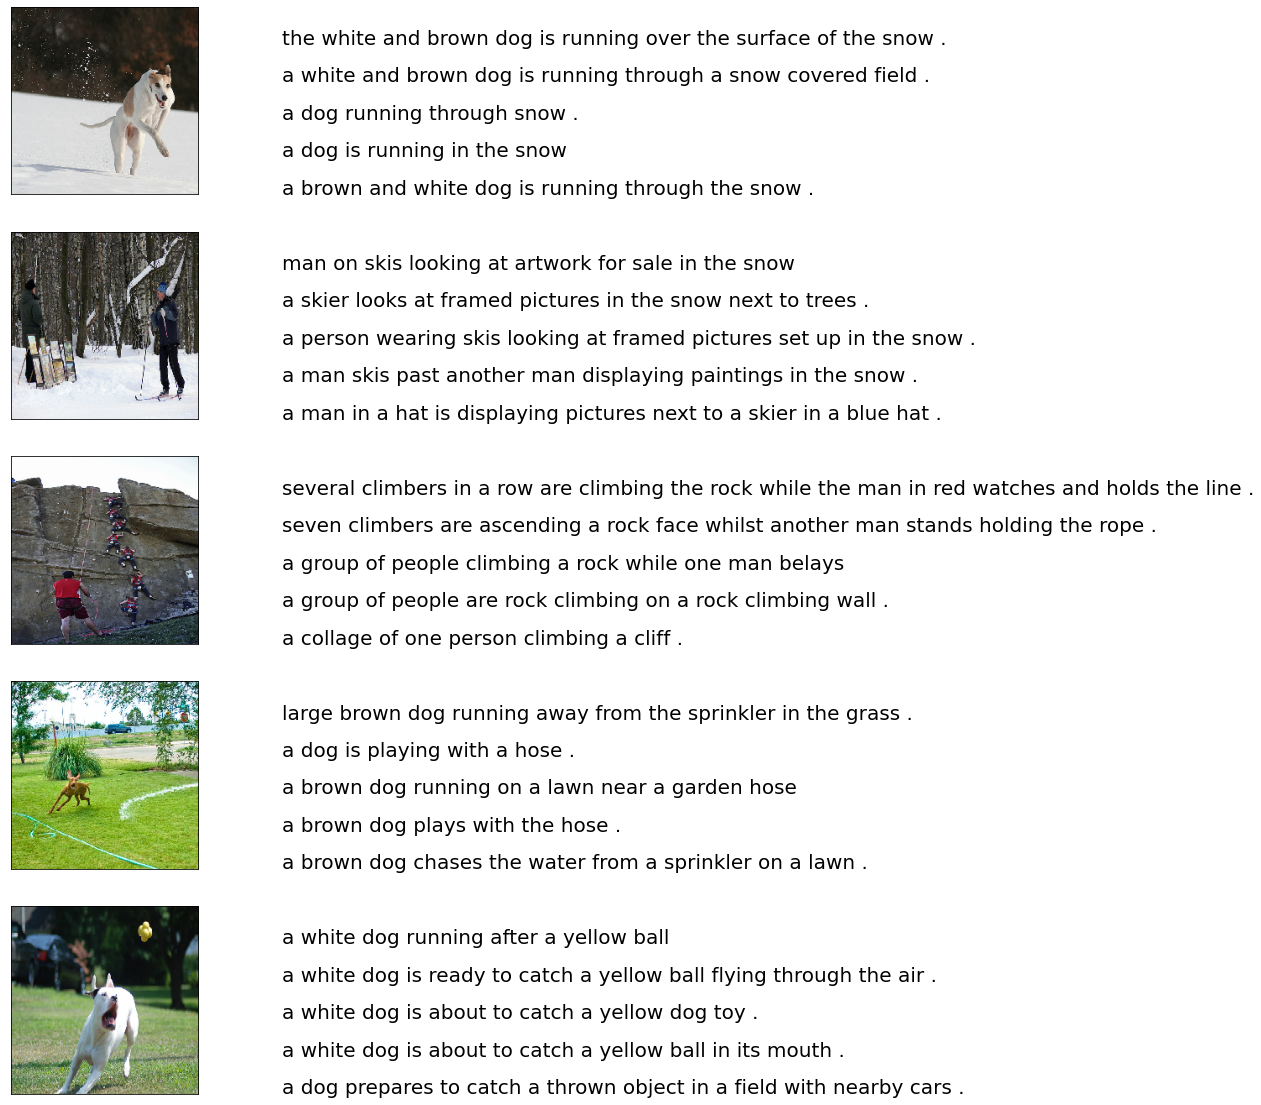

In [14]:
npic = 5
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm in uni_filenames[10:15]:
    filename = image_path + '/' + jpgfnm
    captions = list(data["caption"].loc[data["filename"]==jpgfnm].values)
    image_load = load_img(filename, target_size=target_size)
    
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1
    
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=20)
    count += 1
plt.show()

In [15]:
vocabulary = []
for txt in data.caption.values:
   vocabulary.extend(txt.split())
print('Vocabulary Size: %d' % len(set(vocabulary)))

Vocabulary Size: 8871


In [16]:
def remove_punctuation(text_original):
   text_no_punctuation = text_original.translate(string.punctuation)
   return(text_no_punctuation)

def remove_single_character(text):
   text_len_more_than1 = ""
   for word in text.split():
       if len(word) > 1:
           text_len_more_than1 += " " + word
   return(text_len_more_than1)


In [17]:
def remove_numeric(text):
   text_no_numeric = ""
   for word in text.split():
       isalpha = word.isalpha()
       if isalpha:
           text_no_numeric += " " + word
   return(text_no_numeric)

def text_clean(text_original):
   text = remove_punctuation(text_original)
   text = remove_single_character(text)
   text = remove_numeric(text)
   return(text)

In [18]:
for i, caption in enumerate(data.caption.values):
   newcaption = text_clean(caption)
   data["caption"].iloc[i] = newcaption

In [19]:
clean_vocabulary = []
for txt in data.caption.values:
   clean_vocabulary.extend(txt.split())
print('Clean Vocabulary Size: %d' % len(set(clean_vocabulary)))

Clean Vocabulary Size: 8182


In [20]:
PATH = "./Images/"
all_captions = []
for caption  in data["caption"].astype(str):
    caption = '<start> ' + caption+ ' <end>'
    all_captions.append(caption)

all_captions[:10]

['<start>  child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start>  girl going into wooden building <end>',
 '<start>  little girl climbing into wooden playhouse <end>',
 '<start>  little girl climbing the stairs to her playhouse <end>',
 '<start>  little girl in pink dress going into wooden cabin <end>',
 '<start>  black dog and spotted dog are fighting <end>',
 '<start>  black dog and dog playing with each other on the road <end>',
 '<start>  black dog and white dog with brown spots are staring at each other in the street <end>',
 '<start>  two dogs of different breeds looking at each other on the road <end>',
 '<start>  two dogs on pavement moving toward each other <end>']

In [21]:
all_img_name_vector = []
for annot in data["filename"]:
   full_image_path = PATH + annot
   if(path.isfile(full_image_path)):
     all_img_name_vector.append(full_image_path)

all_img_name_vector[:10]

['./Images/1000268201_693b08cb0e.jpg',
 './Images/1000268201_693b08cb0e.jpg',
 './Images/1000268201_693b08cb0e.jpg',
 './Images/1000268201_693b08cb0e.jpg',
 './Images/1000268201_693b08cb0e.jpg',
 './Images/1001773457_577c3a7d70.jpg',
 './Images/1001773457_577c3a7d70.jpg',
 './Images/1001773457_577c3a7d70.jpg',
 './Images/1001773457_577c3a7d70.jpg',
 './Images/1001773457_577c3a7d70.jpg']

In [22]:
print(f"len(all_img_name_vector) : {len(all_img_name_vector)}")
print(f"len(all_captions) : {len(all_captions)}")

len(all_img_name_vector) : 40455
len(all_captions) : 40455


In [23]:
def data_limiter(num,total_captions,all_img_name_vector):
  train_captions, img_name_vector = shuffle(total_captions,all_img_name_vector,random_state=1)
  train_captions = train_captions[:num]
  img_name_vector = img_name_vector[:num]
  return train_captions,img_name_vector

In [24]:
train_captions,img_name_vector = data_limiter(40000,all_captions,all_img_name_vector)

In [25]:
print(f"len(all_img_name_vector) : {len(img_name_vector)}")
print(f"len(all_captions) : {len(train_captions)}")

len(all_img_name_vector) : 40000
len(all_captions) : 40000


In [26]:
def load_image(image_path):
   img = tf.io.read_file(image_path)
   img = tf.image.decode_jpeg(img, channels=3)
   img = tf.image.resize(img, (299, 299))
   img = tf.keras.applications.inception_v3.preprocess_input(img)
   return img, image_path

image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [27]:
# Get unique images

encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

100%|██████████| 506/506 [02:11<00:00,  3.84it/s]


In [28]:
top_k = 5000

In [29]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [30]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [31]:
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [32]:
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [33]:
cap_vector.shape

(40000, 31)

In [34]:
### Split the data into training and testing

In [35]:
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)

In [36]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(32000, 32000, 8000, 8000)

In [37]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
num_steps = len(img_name_train) // BATCH_SIZE

In [38]:
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [39]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [40]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [41]:
def positional_encoding_1d(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

In [42]:
def positional_encoding_2d(row,col,d_model):
  assert d_model % 2 == 0
  # first d_model/2 encode row embedding and second d_model/2 encode column embedding
  row_pos = np.repeat(np.arange(row),col)[:,np.newaxis]
  col_pos = np.repeat(np.expand_dims(np.arange(col),0),row,axis=0).reshape(-1,1)
  angle_rads_row = get_angles(row_pos,np.arange(d_model//2)[np.newaxis,:],d_model//2)
  angle_rads_col = get_angles(col_pos,np.arange(d_model//2)[np.newaxis,:],d_model//2)
  #apply sin and cos to odd and even indices resp.
  angle_rads_row[:, 0::2] = np.sin(angle_rads_row[:, 0::2])
  angle_rads_row[:, 1::2] = np.cos(angle_rads_row[:, 1::2])
  angle_rads_col[:, 0::2] = np.sin(angle_rads_col[:, 0::2])
  angle_rads_col[:, 1::2] = np.cos(angle_rads_col[:, 1::2])
  pos_encoding = np.concatenate([angle_rads_row,angle_rads_col],axis=1)[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)


In [43]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [44]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [45]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    
  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  #adding -Inf where mask is 1 s.t. value get ignored in softmax

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

In [46]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask=None):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

In [47]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [48]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask=None):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2

In [49]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           look_ahead_mask=None, padding_mask=None):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    # using look ahead mask so that during self attention current query dont consider future token
    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    # use padding mask to avoid padded values of both enc_output and dec_input
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
    return out3, attn_weights_block1, attn_weights_block2

In [50]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff,
               row_size,col_size,rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Dense(self.d_model,activation='relu')
    self.pos_encoding = positional_encoding_2d(row_size,col_size, 
                                            self.d_model)
    
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask=None):
    # shape(x) = (batch_size,seq_len(H*W),features)
    seq_len = tf.shape(x)[1]
    
    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len(H*W), d_model)
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    
    return x  # (batch_size, input_seq_len, d_model)

In [51]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding_1d(maximum_position_encoding, d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, 
           look_ahead_mask=None, padding_mask=None):

    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [52]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff,row_size,col_size, 
               target_vocab_size,max_pos_encoding, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff,row_size,col_size, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size,max_pos_encoding, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
  def call(self, inp, tar , training, look_ahead_mask, dec_padding_mask=None, enc_padding_mask=None):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output, attention_weights

In [53]:
num_layer = 4
d_model = 512
dff = 2048
num_heads = 8
row_size = 8
col_size = 8
target_vocab_size = top_k + 1
dropout_rate = 0.1

In [54]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [55]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

In [56]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [57]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [58]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

In [59]:
def create_masks_decoder(tar):
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  return combined_mask

Training Starts

In [68]:
transformer = Transformer(num_layer,d_model,num_heads,dff,row_size,col_size,target_vocab_size,max_pos_encoding=target_vocab_size,rate=dropout_rate)

In [69]:
@tf.function
def train_step(img_tensor, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  dec_mask = create_masks_decoder(tar_inp)
  
  with tf.GradientTape() as tape:
    predictions, _ = transformer(img_tensor, tar_inp,
                                 True,  
                                 dec_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  train_loss(loss)
  train_accuracy(tar_real, predictions)

In [71]:
for epoch in range(5):
  start = time.time()
  
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  for (batch, (img_tensor, tar)) in enumerate(dataset):
    train_step(img_tensor, tar)
    
    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
    
  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 8.5515 Accuracy 0.0005
Epoch 1 Batch 50 Loss 8.0951 Accuracy 0.0222
Epoch 1 Batch 100 Loss 7.6905 Accuracy 0.0277
Epoch 1 Batch 150 Loss 7.3921 Accuracy 0.0301
Epoch 1 Batch 200 Loss 7.1014 Accuracy 0.0328
Epoch 1 Batch 250 Loss 6.8328 Accuracy 0.0361
Epoch 1 Batch 300 Loss 6.5903 Accuracy 0.0397
Epoch 1 Batch 350 Loss 6.3747 Accuracy 0.0434
Epoch 1 Batch 400 Loss 6.1852 Accuracy 0.0469
Epoch 1 Batch 450 Loss 6.0161 Accuracy 0.0502
Epoch 1 Loss 5.8681 Accuracy 0.0531
Time taken for 1 epoch: 246.17042779922485 secs

Epoch 2 Batch 0 Loss 4.4857 Accuracy 0.0932
Epoch 2 Batch 50 Loss 4.3968 Accuracy 0.0830
Epoch 2 Batch 100 Loss 4.3357 Accuracy 0.0844
Epoch 2 Batch 150 Loss 4.2936 Accuracy 0.0849
Epoch 2 Batch 200 Loss 4.2383 Accuracy 0.0862
Epoch 2 Batch 250 Loss 4.1946 Accuracy 0.0874
Epoch 2 Batch 300 Loss 4.1502 Accuracy 0.0884
Epoch 2 Batch 350 Loss 4.1151 Accuracy 0.0891
Epoch 2 Batch 400 Loss 4.0718 Accuracy 0.0901
Epoch 2 Batch 450 Loss 4.0357 Accuracy 0.0910
E

In [72]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  13658624  
                                                                 
 decoder (Decoder)           multiple                  19376640  
                                                                 
 dense_65 (Dense)            multiple                  2565513   
                                                                 
Total params: 35,600,777
Trainable params: 35,600,777
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# !mkdir -p saved_model
# transformer.save('saved_model/my_model')

In [ ]:
# new_model = tf.keras.models.load_model('saved_model/my_model')

In [73]:
transformer.save_weights('./gdrive/MyDrive/Colab Notebooks/my_transformer/', save_format='tf')

Training Ends

Load Model and Test

In [60]:
transformer34 = Transformer(num_layer,d_model,num_heads,dff,row_size,col_size,target_vocab_size,max_pos_encoding=target_vocab_size,rate=dropout_rate)

In [61]:
transformer34.compile(loss='sparse_categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9))

In [62]:
@tf.function
def train_step34(img_tensor, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  dec_mask = create_masks_decoder(tar_inp)
  
  with tf.GradientTape() as tape:
    predictions, _ = transformer34(img_tensor, tar_inp, 
                                 True,  
                                 dec_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer34.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer34.trainable_variables))
  
  train_loss(loss)
  train_accuracy(tar_real, predictions)

In [63]:
start = time.time()

train_loss.reset_states()
train_accuracy.reset_states()

for (batch, (img_tensor, tar)) in enumerate(dataset):
  train_step34(img_tensor, tar)
  
  print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
        1, batch, train_loss.result(), train_accuracy.result()))
  # break
  
print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(1, 
                                              train_loss.result(), 
                                              train_accuracy.result()))

print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 8.6636 Accuracy 0.0000
Epoch 1 Batch 1 Loss 8.6392 Accuracy 0.0000
Epoch 1 Batch 2 Loss 8.6545 Accuracy 0.0000
Epoch 1 Batch 3 Loss 8.6533 Accuracy 0.0000
Epoch 1 Batch 4 Loss 8.6438 Accuracy 0.0001
Epoch 1 Batch 5 Loss 8.6377 Accuracy 0.0001
Epoch 1 Batch 6 Loss 8.6327 Accuracy 0.0001
Epoch 1 Batch 7 Loss 8.6285 Accuracy 0.0001
Epoch 1 Batch 8 Loss 8.6207 Accuracy 0.0001
Epoch 1 Batch 9 Loss 8.6177 Accuracy 0.0001
Epoch 1 Batch 10 Loss 8.6117 Accuracy 0.0000
Epoch 1 Batch 11 Loss 8.6036 Accuracy 0.0000
Epoch 1 Batch 12 Loss 8.5977 Accuracy 0.0000
Epoch 1 Batch 13 Loss 8.5916 Accuracy 0.0000
Epoch 1 Batch 14 Loss 8.5836 Accuracy 0.0000
Epoch 1 Batch 15 Loss 8.5719 Accuracy 0.0000
Epoch 1 Batch 16 Loss 8.5612 Accuracy 0.0000
Epoch 1 Batch 17 Loss 8.5539 Accuracy 0.0000
Epoch 1 Batch 18 Loss 8.5429 Accuracy 0.0002
Epoch 1 Batch 19 Loss 8.5322 Accuracy 0.0004
Epoch 1 Batch 20 Loss 8.5207 Accuracy 0.0010
Epoch 1 Batch 21 Loss 8.5080 Accuracy 0.0020
Epoch 1 Batch 22 Los

In [64]:
transformer34.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  13658624  
                                                                 
 decoder (Decoder)           multiple                  19376640  
                                                                 
 dense_65 (Dense)            multiple                  2565513   
                                                                 
Total params: 35,600,777
Trainable params: 35,600,777
Non-trainable params: 0
_________________________________________________________________


In [65]:
transformer34.load_weights('./gdrive/MyDrive/Colab Notebooks/my_transformer/')

In [66]:
transformer34.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  13658624  
                                                                 
 decoder (Decoder)           multiple                  19376640  
                                                                 
 dense_65 (Dense)            multiple                  2565513   
                                                                 
Total params: 35,600,777
Trainable params: 35,600,777
Non-trainable params: 0
_________________________________________________________________


In [67]:
transformer.summary()

NameError: ignored

In [68]:
def evaluate(image):

  temp_input = tf.expand_dims(load_image(image)[0], 0)
  img_tensor_val = image_features_extract_model(temp_input)
  img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
  
  start_token = tokenizer.word_index['<start>']
  end_token = tokenizer.word_index['<end>']
   
  #decoder input is start token.
  decoder_input = [start_token]
  output = tf.expand_dims(decoder_input, 0) #tokens
  result = [] #word list

  for i in range(100):
      dec_mask = create_masks_decoder(output)
  
      # predictions.shape == (batch_size, seq_len, vocab_size)
      predictions, attention_weights = transformer34(img_tensor_val,output,False,dec_mask)
      
      # select the last word from the seq_len dimension
      predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

      predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
      # return the result if the predicted_id is equal to the end token
      if predicted_id == end_token:
          return result,tf.squeeze(output, axis=0), attention_weights
      # concatentate the predicted_id to the output which is given to the decoder
      # as its input.
      result.append(tokenizer.index_word[int(predicted_id)])
      output = tf.concat([output, predicted_id], axis=-1)

  return result,tf.squeeze(output, axis=0), attention_weights

BLEU-1 score: 0
BLEU-2 score: 0
BLEU-3 score: 0
BLEU-4 score: 0
Real Caption: scene at an indian wedding
Predicted Caption: man and woman are wearing red and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white shirts


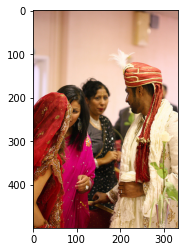

In [71]:
start_token = tokenizer.word_index['<start>']
end_token = tokenizer.word_index['<end>']
# select random image from validation data
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_weights = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

#remove <end> from result         
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption
score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")

print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)

In [105]:
def evaluate(image):

  # temp_input = tf.expand_dims(load_image(image)[0], 0)
  temp_input = tf.expand_dims(image, 0)
  img_tensor_val = image_features_extract_model(temp_input)
  img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
  
  start_token = tokenizer.word_index['<start>']
  end_token = tokenizer.word_index['<end>']
   
  #decoder input is start token.
  decoder_input = [start_token]
  output = tf.expand_dims(decoder_input, 0) #tokens
  result = [] #word list

  for i in range(100):
      dec_mask = create_masks_decoder(output)
  
      # predictions.shape == (batch_size, seq_len, vocab_size)
      predictions, attention_weights = transformer(img_tensor_val,output,False,dec_mask)
      
      # select the last word from the seq_len dimension
      predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

      predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
      # return the result if the predicted_id is equal to the end token
      if predicted_id == end_token:
          return result,tf.squeeze(output, axis=0), attention_weights
      # concatentate the predicted_id to the output which is given to the decoder
      # as its input.
      result.append(tokenizer.index_word[int(predicted_id)])
      output = tf.concat([output, predicted_id], axis=-1)

  return result,tf.squeeze(output, axis=0), attention_weights

BLEU-1 score: 0
BLEU-2 score: 0
BLEU-3 score: 0
BLEU-4 score: 0
Real Caption: man with yellow vest shovels rocks while another man watches
Predicted Caption: women in colorful dresses are dancing in the street


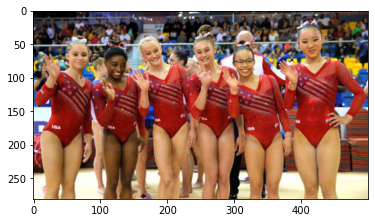

In [96]:
start_token = tokenizer.word_index['<start>']
end_token = tokenizer.word_index['<end>']
# select random image from validation data
rid = np.random.randint(0, len(img_name_val))
image = './img4.jpeg'
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_weights = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

#remove <end> from result         
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption
score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")

print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)

+ Keyframe Extraction

In [2]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import svds, eigs

def getKeyframes(path):
  # Cell 1

  cap = cv2.VideoCapture(path) 
  arr = np.empty((0, 1944), int)
  D = dict()
  count = 0
  start_time = time.time()
  while cap.isOpened():
      ret, frame = cap.read()
      if ret == True:
          frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
          D[count] = frame_rgb   
          height, width, channels = frame_rgb.shape

          if height % 3 == 0:
              h_chunk = int(height/3)
          else:
              h_chunk = int(height/3) + 1

          if width % 3 == 0:
              w_chunk = int(width/3)
          else:
              w_chunk = int(width/3) + 1

          h = 0
          w = 0 
          feature_vector = []
          for a in range(1,4):
              h_window = h_chunk*a
              for b in range(1,4):
                  frame = frame_rgb[h : h_window, w : w_chunk*b , :]
                  hist = cv2.calcHist(frame, [0, 1, 2], None, [6, 6, 6], [0, 256, 0, 256, 0, 256])#finding histograms for each block  
                  hist1= hist.flatten()  #flatten the hist to one-dimensinal vector 
                  feature_vector += list(hist1)
                  w = w_chunk*b
                  
              h = h_chunk*a
              w = 0
          arr = np.vstack((arr, feature_vector ))
          count+=1
      else:
          break
  final_arr = arr.transpose()

  # Cell 2
  A = csc_matrix(final_arr, dtype=float)
  u, s, vt = svds(A, k = 63)

  # Cell 3
  v1_t = vt.transpose()
  projections = v1_t @ np.diag(s)

  # Cell 4
  f=projections
  C = dict()
  for i in range(f.shape[0]):
      C[i] = np.empty((0,63), int)
  C[0] = np.vstack((C[0], f[0]))   
  C[0] = np.vstack((C[0], f[1]))

  E = dict()
  for i in range(projections.shape[0]):
      E[i] = np.empty((0,63), int)
      
  E[0] = np.mean(C[0], axis=0)

  count = 0
  for i in range(2,f.shape[0]):
      similarity = np.dot(f[i], E[count])/( (np.dot(f[i],f[i]) **.5) * (np.dot(E[count], E[count]) ** .5)) 
      if similarity < 0.9:
          count+=1         
          C[count] = np.vstack((C[count], f[i])) 
          E[count] = np.mean(C[count], axis=0)   
      else:
          C[count] = np.vstack((C[count], f[i])) 
          E[count] = np.mean(C[count], axis=0)

  # Cell 5
  b = []
  for i in range(f.shape[0]):
      b.append(C[i].shape[0])
  last = b.index(0) 
  b1=b[:last]

  # Cell 6
  res = [idx for idx, val in enumerate(b1) if val >= 25]

  # Cell 7
  GG = C
  for i in range(last):
      p1= np.repeat(i, b1[i]).reshape(b1[i],1)
      GG[i] = np.hstack((GG[i],p1))

  # Cell 8
  F =  np.empty((0,64), int) 
  for i in range(last):
      F = np.vstack((F,GG[i]))
    
  # Cell 9
  colnames = []
  for i in range(1, 65):
      col_name = "v" + str(i)
      colnames+= [col_name]
  df = pd.DataFrame(F, columns= colnames)

  # Cell 10
  df['v64']= df['v64'].astype(int)

  # Cell 11
  df1 =  df[df.v64.isin(res)]

  # Cell 12
  new = df1.groupby('v64').tail(1)['v64']

  # Cell 13
  new1 = new.index

  # Cell 14
  i = 0
  for c in new1:
    frame_rgb1 = cv2.cvtColor(D[c], cv2.COLOR_RGB2BGR) #since cv consider image in BGR order
    frame_num_chr = str(c)
    file_name = 'frame'+ str(i) +'.png'
    cv2.imwrite(file_name, frame_rgb1)
    i += 1
  return i

In [ ]:
keyframes = getKeyframes('./Olympics.mp4')

Predicted Caption: man is sitting on the top of the side of the road
Predicted Caption: man is standing on top of mountain covered in the snow
Predicted Caption: two people are standing on mountain
Predicted Caption: man is standing on top of mountain covered mountain
Predicted Caption: group of people are sitting in front of building
Predicted Caption: girl with red hair and white hair is holding cup
Predicted Caption: man with glasses and glasses is wearing white shirt
Predicted Caption: two people are sitting in the window of
Predicted Caption: two children are playing with red balls
Predicted Caption: group of people are standing on the ground
Predicted Caption: man with mohawk is holding up paper cup
Predicted Caption: two young girls are standing in front of crowd
Predicted Caption: two people are standing in front of large building
Predicted Caption: two women in colorful dresses are standing in front of building
Predicted Caption: man with mohawk is holding up sign
Predicted Ca

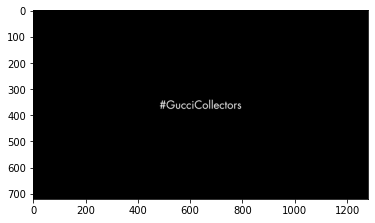

In [74]:
big_caption = ""
for i in range(keyframes):
  start_token = tokenizer.word_index['<start>']
  end_token = tokenizer.word_index['<end>']
  # select random image from validation data
  image = './frame' + str(i) + '.png'

  caption,result,attention_weights = evaluate(image)

  #remove "<unk>" in result
  for i in caption:
      if i=="<unk>":
          caption.remove(i)

  for i in real_caption:
      if i=="<unk>":
          real_caption.remove(i)

  #remove <end> from result         
  result_join = ' '.join(caption)
  result_final = result_join.rsplit(' ', 1)[0]
  # candidate = caption
  # score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
  # print(f"BLEU-1 score: {score*100}")
  # score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
  # print(f"BLEU-2 score: {score*100}")
  # score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
  # print(f"BLEU-3 score: {score*100}")
  # score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
  # print(f"BLEU-4 score: {score*100}")

  # print ('Real Caption:', real_caption)
  print ('Predicted Caption:', ' '.join(caption))
  big_caption += ' '.join(caption)
  big_caption += ". "
  temp_image = np.array(Image.open(image))
  plt.imshow(temp_image)

# New section

In [1]:
big_caption = 'man is sitting on the top of the side of the road. man is standing on top of mountain covered in the snow. two people are standing on mountain. man is standing on top of mountain covered mountain. group of people are sitting in front of building. girl with red hair and white hair is holding cup. man with glasses and glasses is wearing white shirt. two people are sitting in the window of. two children are playing with red balls. group of people are standing on the ground. man with mohawk is holding up paper cup. two young girls are standing in front of crowd. two people are standing in front of large building. two women in colorful dresses are standing in front of building. man with mohawk is holding up sign. girl in red shirt and white top is smiling. two women are standing in front of building. man with mohawk and woman are looking at the camera. man and woman are standing in front of crowd. man with mohawk is wearing red shirt and white shirt. man and woman are standing in front of building. people are standing in front of crowd. man and woman are standing in front of building. group of people are standing in front of building. man is standing in front of white building.'

In [2]:
!pip install transformers

In [3]:
from transformers import pipeline

In [4]:
summarizer = pipeline('summarization')

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 (https://huggingface.co/sshleifer/distilbart-cnn-12-6)


In [5]:
summary = big_caption

In [6]:
summarizer(summary, max_length=200, min_length=50, do_sample=False)

[{'summary_text': ' Group of people are sitting in the window of two children are playing with red balls . Two young girls are standing in front of crowd. two people are standing on mountain. man is sitting on the top of the side of the road. man with mohawk is holding up paper cup.'}]